In [1]:
#!/bin/python3
import numpy as np
import matplotlib.pylab as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/lib/python3/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## Constantes

In [5]:
MHZ = 1.0e6
KHZ = 1.0e3
c = 299792458.0
fc = 436.0*10
_lambda = c/fc
k = 2*np.pi/_lambda
d = _lambda/2
mx = 4
my = 4
nSamples = 1024**2
fs = 32*KHZ
total_time = nSamples/fs


## Contador

In [4]:
array = np.arange(16)

In [5]:

output = np.zeros((nSamples,16), dtype='short')
for i in range(nSamples):
    output[i,:] = array

In [6]:
np.save("./test/contador_bytes_al_reves.npy", output)

## Generemos señal desfasada nostros mismos

In [3]:
#incoming angles
theta = np.radians(15.)
phi = np.radians(80.)
print(theta, phi-np.pi)

0.2617993877991494 -1.7453292519943295


In [4]:
np.degrees(-2.88) + 180

14.988155002322912

In [4]:
fc = 0

In [5]:
complex_wave = np.exp(1j*2*np.pi*fc*np.arange(nSamples, dtype='complex64')/fs)

In [6]:
#Generate signal [s_1;s_2;...;s_size]*[1, ..., np.exp(-1j*k*d((mx-1)*cos(theta)*cos(phi) + (my-1)*cos(theta)*sin(phi)))]
def simulatePhasedArray(signal):
    deltas = np.empty((mx*my, 1), dtype=np.complex64)
    for i in range(mx):
        for j in range(my):
            deltas[i*my+j] = i*np.cos(phi) + j*np.sin(phi)
    phase_deltas = np.exp(-1j*k*d*np.cos(theta)*deltas)
    return np.kron(signal, phase_deltas).T


In [7]:
signal = simulatePhasedArray(complex_wave)
np.shape(signal)

(1048576, 16)

In [8]:
flattened_signal = signal.flatten()

In [11]:
np.save("./test/real_frec_0_complex.npy", flattened_signal)

## Ahora simulemos el muestreo pasabanda

In [15]:
fc = 146*MHZ
fs = 65*MHZ
nSamples = 1024**2

lambda_ = c/fc
k = 2*np.pi/lambda_
d = lambda_/2
theta = np.radians(60.)
phi = np.radians(15.)


In [24]:
complex_wave = np.exp(1j*2*np.pi*fc*np.arange(nSamples, dtype='complex64')/fs)
#complex_wave = np.float16(np.cos(2*np.pi*fc*np.arange(nSamples, dtype=np.ushort)/fs)) + 1j*np.float16(np.sin(2*np.pi*fc*np.arange(nSamples, dtype=np.ushort)/fs))

In [18]:
print(np.result_type(complex_wave))
print(np.result_type(complex_wave.real))
print(len(complex_wave))

complex64
float32
1048576


(0.0, 209.7152)

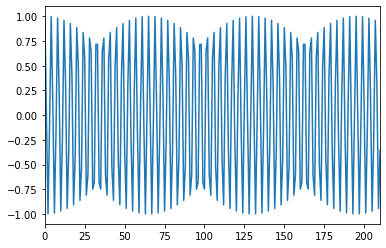

In [23]:
plt.plot(complex_wave.real)
plt.xlim(0, nSamples/5e3)

(0.0, 209.7152)

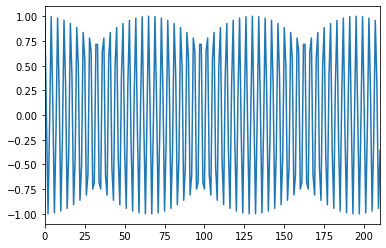

In [25]:
plt.plot(complex_wave.real)
plt.xlim(0, nSamples/5e3)

In [21]:
print(np.result_type(np.fft.fft(complex_wave)))

complex128


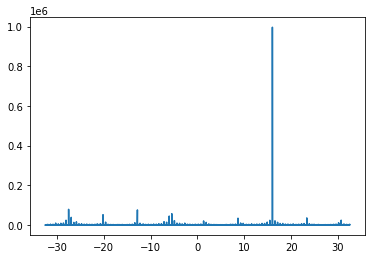

In [26]:
frecs = np.linspace(-fs/2,fs/2,len(complex_wave))/MHZ
plt.plot(frecs,abs(np.fft.fftshift(np.fft.fft(complex_wave))))


In [26]:
def simulatePhasedArray(signal):
    deltas = np.empty((mx*my, 1), dtype=np.complex64)
    for i in range(mx):
        for j in range(my):
            deltas[i*my+j] = i*np.cos(phi) + j*np.sin(phi)
    phase_deltas = np.exp(1j*k*d*np.cos(theta)*deltas)
    return np.kron(signal, phase_deltas).T

In [27]:
signal = simulatePhasedArray(complex_wave)

In [28]:
np.shape(signal)

(1048576, 16)

(400000.0, 400100.0)

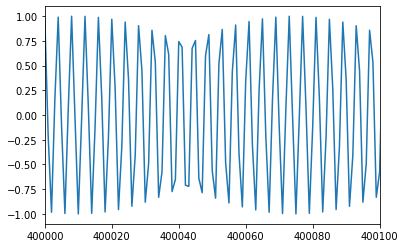

In [29]:
ejeX = np.linspace(0, nSamples//fs, num=nSamples)
plt.plot(signal[:,2].real)
plt.xlim([4e5,4.001e5])

In [33]:
np.save("./test/submuestreada_real.npy", signal.flatten().real)

In [12]:
np.degrees(1.39)

79.64113352318442

In [54]:
np.degrees(0.26)

14.896902673401405

## Generemos la señal modulada

In [17]:
def modulateQPSK(coef_sequence):
    t = np.zeros(nSamples, dtype=np.complex64)
    even_sequence = coef_sequence[0::2]
    odd_sequence = coef_sequence[1::2]
    t_simbolo = total_time/len(even_sequence)
    for i in range(len(even_sequence)):
        t_inicio = i*t_simbolo
        t_final = (i + 1)*t_simbolo
        interval = np.ones(int(t_final*fs) - int(t_inicio*fs)) #np.ones(int(t_simbolo*fs))
        pam_even_interval = even_sequence[i]*interval
        pam_odd_interval = odd_sequence[i]*interval
        
        phase_buffer = np.linspace(t_inicio, t_final - 1/fs , num=len(interval))
        cos_interval = np.cos(2*np.pi*fc*phase_buffer)
        sin_interval = np.sin(2*np.pi*fc*phase_buffer)
        # t[int(t_inicio*fs):int(t_final*fs)] = pam_even_interval*cos_interval + pam_odd_interval*sin_interval
        #As complex wave
        t[int(t_inicio*fs):int(t_final*fs)] = pam_even_interval*cos_interval + 1j*pam_odd_interval*sin_interval
  
    return t

In [18]:
coef_sequence =  choice([-1,1], size=2000)

In [19]:
modulatedSignal = modulateQPSK(coef_sequence)

TypeError: 'float' object cannot be interpreted as an integer

(1.0, 1.01)

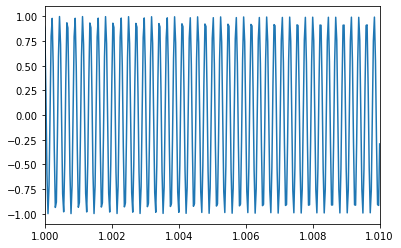

In [ ]:
ejeX = np.linspace(0, total_time, num=nSamples)
plot(ejeX, modulatedSignal.real)
plt.xlim(1,1.01)

In [ ]:
receivedModulatedSignal = simulatePhasedArray(modulatedSignal)

In [ ]:
np.save("./test/receivedModulatedSignal.npy", receivedModulatedSignal.flatten())

In [ ]:
np.degrees(-1.63)

-93.39212060632418

## Tests tmp

In [7]:
np.save("./test/save_test.npy", np.arange(5, dtype=np.float32))

In [5]:
np.save("./test/save_test.npy", np.arange(4)+ 5)